In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import pickle as pkl
from tensorflow import keras
import tensorflow.keras.backend as K
from keras.models import Sequential,Model
from keras.models import Sequential 
from keras.layers import Dense, Dropout, Flatten, Input, Reshape, BatchNormalization, Bidirectional, LSTM, Multiply, Activation, Normalization, TimeDistributed
from keras.layers import Conv3D, Conv2D, Conv1D, MaxPool3D, MaxPool2D, MaxPool1D, AvgPool3D, AvgPool2D, AvgPool1D, GlobalMaxPool3D, Attention, Subtract
from keras.layers import GlobalMaxPool2D, GlobalMaxPool1D, SpatialDropout3D, SpatialDropout2D, SpatialDropout1D, GlobalAvgPool3D, MultiHeadAttention
from keras.layers import GlobalAvgPool2D, GlobalAvgPool1D, SeparableConv2D, SeparableConv1D, Add, Concatenate, LeakyReLU, ELU, Activation, PReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from keras.utils import np_utils
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_recall_fscore_support
from sklearn.utils.class_weight import compute_class_weight
import gc

# **Data Loading**

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
gc.collect()

Mounted at /content/drive/


58

In [ ]:
input_path='/content/drive/MyDrive/data_preprocessed_python/'

In [ ]:
def baseline_remove(XR):
  XT = XR[:, 384:]
  XB_ = (XR[:, :1*128] + XR[:, 1*128:2*128] + XR[:, 2*128:3*128])/3.0
  for i in range(60):
    XT[:, i*128:(i+1)*128] = XT[:, i*128:(i+1)*128] - XB_
  return XT


In [ ]:
new_channels = [0,1,18,2,3,5,4,23,6,7,9,8,15,10,11,12,14,13,
 16,17,18,19,20,22,21,23,24,25,27,26,15,28,29,30,14,31]

In [ ]:
eeg_signal = []
valence = []
arousal = []
window_size = 256
no_channels = 32
no_new_channels = len(new_channels)
no_videos = 40
Trsld = 5

for person in range(2,3):
  print('Person No.' + str(person))
  
  
  # EEG files address
  if person < 10 :
    address = input_path+'s0'+str(person)+'.dat'
  else :
    address = input_path+'s'+str(person)+'.dat'

  with open(address, 'rb') as file:
    data = pkl.load(file, encoding = 'latin1')

  eeg = data['data']
  label = data['labels']
  
  # Assigning classes
  label[label<Trsld] = 0
  label[label>=Trsld] = 1

  val = label.T[0] # Valence label
  aro = label.T[1] # Arousal label

  del data, label
  # Iterating through 40 vidoes/trials
  for i in range(no_videos):
    sig = eeg[i][:no_channels, :]
    sig = baseline_remove(sig)
    temp = []
    for j in new_channels:
      temp.append(sig[j, :])
    sig = np.reshape(temp,[no_new_channels,-1])
    # Segmenting into 2 seconds (256 timesteps) windows without overlap
    start = 0
    while start + window_size <=sig.shape[1]:
      eeg_signal.append(sig[:, start:start+window_size].T)
      valence.append(val[i])
      arousal.append(aro[i])
      start += window_size 
  del eeg, val, aro, sig
eeg_signal = np.reshape(eeg_signal,[-1,window_size,no_new_channels])
data = np.asarray(eeg_signal, dtype = np.float32) # Using 32 bit floating point value to save memory
del eeg_signal
valence = np.asarray(valence, dtype = np.int8)
arousal = np.asarray(arousal, dtype = np.int8)

print(data.shape)
print(valence.shape, valence[valence == 0].shape, valence[valence == 1].shape)
print(arousal.shape, arousal[arousal == 0].shape, arousal[arousal == 1].shape)

valence = np_utils.to_categorical(valence)
arousal = np_utils.to_categorical(arousal)
gc.collect()

Person No.2
(1200, 256, 36)
(1200,) (450,) (750,)
(1200,) (480,) (720,)


3750

In [ ]:
def simple_2D_CNN(x): 
  x = BatchNormalization()(x)
  x = Bidirectional(LSTM(32, return_sequences=True))(x)
  x = Bidirectional(LSTM(32, return_sequences=True))(x)
  x = Bidirectional(LSTM(32, return_sequences=True))(x)
  x = Bidirectional(LSTM(32, return_sequences=True))(x)
  x = Bidirectional(LSTM(32, return_sequences=False))(x)
  x = BatchNormalization()(x)
  x = Dropout(0.4)(x)
  x = Dense(32, activation='relu')(x)
  x = Dropout(0.1)(x)
  x = Dense(2, activation='softmax')(x)
  return x

def get_model(): 
  input_shape = (data.shape[1], data.shape[2]) 
  a = Input(input_shape) 
  out = simple_2D_CNN(a) 
  model = Model(a, out) 
  opt = keras.optimizers.Adam(learning_rate=1e-04) 
  model.compile(loss=keras.losses.categorical_crossentropy, metrics=["accuracy"], optimizer=opt) 
  return model 
model = get_model() 
model.summary() 

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 256, 36)]         0         
                                                                 
 batch_normalization_8 (Batc  (None, 256, 36)          144       
 hNormalization)                                                 
                                                                 
 bidirectional_16 (Bidirecti  (None, 256, 64)          17664     
 onal)                                                           
                                                                 
 bidirectional_17 (Bidirecti  (None, 256, 64)          24832     
 onal)                                                           
                                                                 
 bidirectional_18 (Bidirecti  (None, 256, 64)          24832     
 onal)                                                     

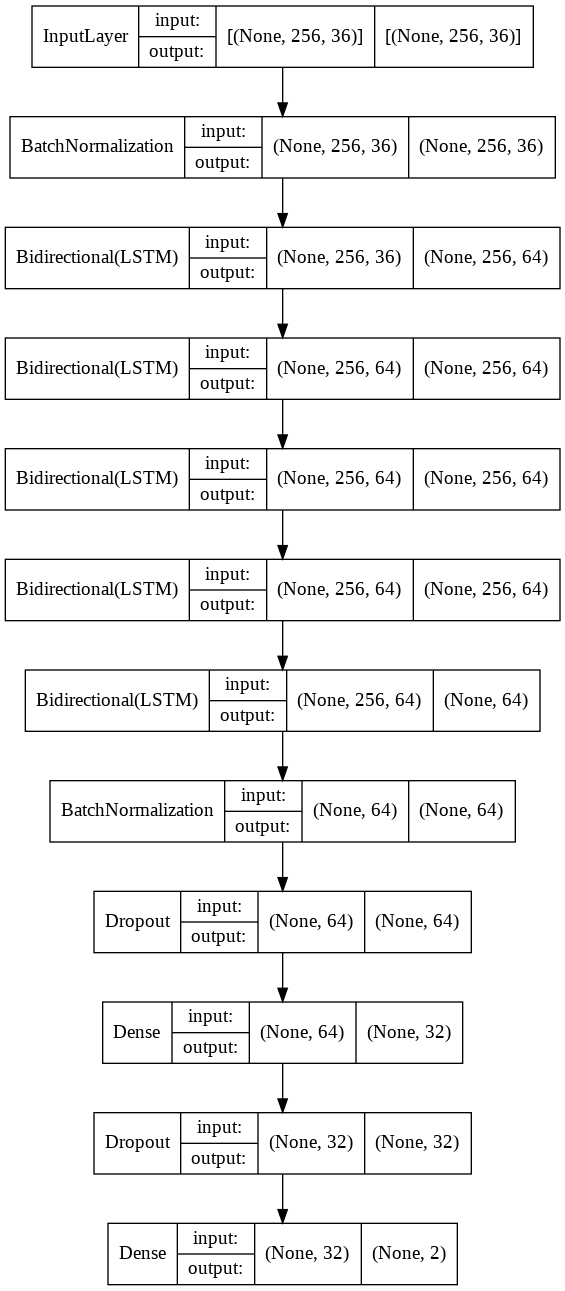

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=False)

In [ ]:
batch_size = 64
epochs = 100
kfold = KFold(n_splits=10, random_state=1, shuffle=True)
gc.collect()

40084

In [ ]:
def call_class_weights(yt):
  y_integers = np.argmax(yt, axis=1)
  class_weights = compute_class_weight(class_weight = 'balanced', classes = np.unique(y_integers), y = y_integers)
  d_class_weights = dict(enumerate(class_weights))
  return d_class_weights

# **Valence**

In [ ]:
#valence
X_train, x_test, Y_train, y_test = train_test_split(data, valence, test_size=0.1, random_state=4)
print(X_train.shape,x_test.shape,Y_train.shape,y_test.shape)

(1080, 256, 36) (120, 256, 36) (1080, 2) (120, 2)


Results for fold 1
Epoch 1/120
16/16 [==============================] - 18s 320ms/step - loss: 0.8724 - accuracy: 0.6132 - val_loss: 0.6848 - val_accuracy: 0.6204
Epoch 2/120
16/16 [==============================] - 2s 119ms/step - loss: 0.7528 - accuracy: 0.6276 - val_loss: 0.6888 - val_accuracy: 0.5463
Epoch 3/120
16/16 [==============================] - 2s 117ms/step - loss: 0.7037 - accuracy: 0.6523 - val_loss: 0.6906 - val_accuracy: 0.5185
Epoch 4/120
16/16 [==============================] - 2s 118ms/step - loss: 0.6975 - accuracy: 0.6553 - val_loss: 0.6911 - val_accuracy: 0.5000
Epoch 5/120
16/16 [==============================] - 2s 115ms/step - loss: 0.6698 - accuracy: 0.6800 - val_loss: 0.6920 - val_accuracy: 0.5000
Epoch 6/120
16/16 [==============================] - 2s 118ms/step - loss: 0.6278 - accuracy: 0.6821 - val_loss: 0.6913 - val_accuracy: 0.5000
Epoch 7/120
16/16 [==============================] - 2s 119ms/step - loss: 0.6089 - accuracy: 0.6893 - val_loss: 0.6907 - 

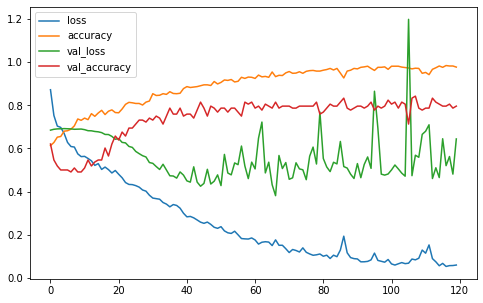

Results for fold 2
Epoch 1/120
16/16 [==============================] - 18s 319ms/step - loss: 0.9139 - accuracy: 0.4280 - val_loss: 0.6934 - val_accuracy: 0.5093
Epoch 2/120
16/16 [==============================] - 2s 109ms/step - loss: 0.7677 - accuracy: 0.5000 - val_loss: 0.6891 - val_accuracy: 0.5833
Epoch 3/120
16/16 [==============================] - 2s 113ms/step - loss: 0.7378 - accuracy: 0.5350 - val_loss: 0.6866 - val_accuracy: 0.6019
Epoch 4/120
16/16 [==============================] - 2s 116ms/step - loss: 0.6821 - accuracy: 0.5772 - val_loss: 0.6844 - val_accuracy: 0.6574
Epoch 5/120
16/16 [==============================] - 2s 114ms/step - loss: 0.6651 - accuracy: 0.6070 - val_loss: 0.6825 - val_accuracy: 0.6204
Epoch 6/120
16/16 [==============================] - 2s 117ms/step - loss: 0.6412 - accuracy: 0.6235 - val_loss: 0.6807 - val_accuracy: 0.6481
Epoch 7/120
16/16 [==============================] - 2s 111ms/step - loss: 0.6262 - accuracy: 0.6214 - val_loss: 0.6785 - 

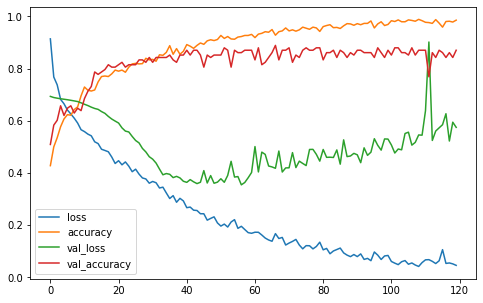

Results for fold 3
Epoch 1/120
16/16 [==============================] - 18s 315ms/step - loss: 0.8994 - accuracy: 0.5833 - val_loss: 0.6888 - val_accuracy: 0.5741
Epoch 2/120
16/16 [==============================] - 2s 115ms/step - loss: 0.7677 - accuracy: 0.6193 - val_loss: 0.6932 - val_accuracy: 0.5093
Epoch 3/120
16/16 [==============================] - 2s 116ms/step - loss: 0.6888 - accuracy: 0.6687 - val_loss: 0.6944 - val_accuracy: 0.5000
Epoch 4/120
16/16 [==============================] - 2s 117ms/step - loss: 0.6839 - accuracy: 0.6471 - val_loss: 0.6952 - val_accuracy: 0.4815
Epoch 5/120
16/16 [==============================] - 2s 116ms/step - loss: 0.6467 - accuracy: 0.6595 - val_loss: 0.6958 - val_accuracy: 0.4815
Epoch 6/120
16/16 [==============================] - 2s 118ms/step - loss: 0.6096 - accuracy: 0.6996 - val_loss: 0.6953 - val_accuracy: 0.4815
Epoch 7/120
16/16 [==============================] - 2s 114ms/step - loss: 0.5945 - accuracy: 0.7027 - val_loss: 0.6958 - 

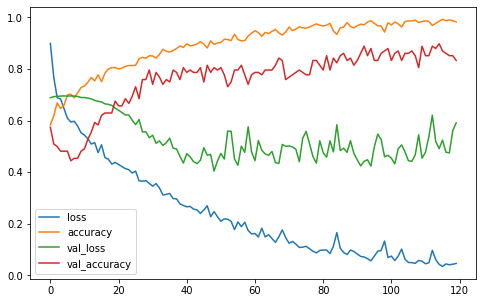

Results for fold 4
Epoch 1/120
16/16 [==============================] - 17s 312ms/step - loss: 0.8273 - accuracy: 0.4681 - val_loss: 0.6847 - val_accuracy: 0.6019
Epoch 2/120
16/16 [==============================] - 2s 119ms/step - loss: 0.7297 - accuracy: 0.5741 - val_loss: 0.6866 - val_accuracy: 0.6204
Epoch 3/120
16/16 [==============================] - 2s 119ms/step - loss: 0.6812 - accuracy: 0.6101 - val_loss: 0.6862 - val_accuracy: 0.5926
Epoch 4/120
16/16 [==============================] - 2s 119ms/step - loss: 0.6419 - accuracy: 0.6358 - val_loss: 0.6846 - val_accuracy: 0.6204
Epoch 5/120
16/16 [==============================] - 2s 118ms/step - loss: 0.6311 - accuracy: 0.6564 - val_loss: 0.6822 - val_accuracy: 0.6111
Epoch 6/120
16/16 [==============================] - 2s 118ms/step - loss: 0.6118 - accuracy: 0.6605 - val_loss: 0.6797 - val_accuracy: 0.6481
Epoch 7/120
16/16 [==============================] - 2s 117ms/step - loss: 0.5995 - accuracy: 0.6831 - val_loss: 0.6771 - 

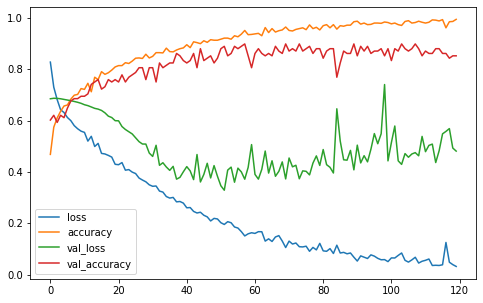

Results for fold 5
Epoch 1/120
16/16 [==============================] - 17s 315ms/step - loss: 0.7589 - accuracy: 0.5751 - val_loss: 0.6886 - val_accuracy: 0.6204
Epoch 2/120
16/16 [==============================] - 2s 120ms/step - loss: 0.7271 - accuracy: 0.5689 - val_loss: 0.6876 - val_accuracy: 0.6204
Epoch 3/120
16/16 [==============================] - 2s 117ms/step - loss: 0.6761 - accuracy: 0.6183 - val_loss: 0.6877 - val_accuracy: 0.6019
Epoch 4/120
16/16 [==============================] - 2s 119ms/step - loss: 0.6589 - accuracy: 0.6265 - val_loss: 0.6880 - val_accuracy: 0.5926
Epoch 5/120
16/16 [==============================] - 2s 117ms/step - loss: 0.6657 - accuracy: 0.6337 - val_loss: 0.6879 - val_accuracy: 0.5556
Epoch 6/120
16/16 [==============================] - 2s 119ms/step - loss: 0.6326 - accuracy: 0.6533 - val_loss: 0.6852 - val_accuracy: 0.5926
Epoch 7/120
16/16 [==============================] - 2s 118ms/step - loss: 0.6480 - accuracy: 0.6502 - val_loss: 0.6821 - 

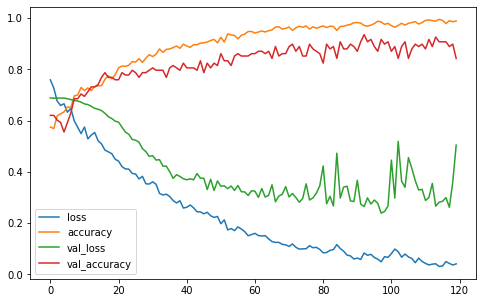

Results for fold 6
Epoch 1/120
16/16 [==============================] - 18s 321ms/step - loss: 0.8225 - accuracy: 0.4311 - val_loss: 0.6947 - val_accuracy: 0.4907
Epoch 2/120
16/16 [==============================] - 2s 118ms/step - loss: 0.7394 - accuracy: 0.4774 - val_loss: 0.6889 - val_accuracy: 0.5463
Epoch 3/120
16/16 [==============================] - 2s 119ms/step - loss: 0.6982 - accuracy: 0.5432 - val_loss: 0.6854 - val_accuracy: 0.6667
Epoch 4/120
16/16 [==============================] - 2s 118ms/step - loss: 0.6704 - accuracy: 0.5700 - val_loss: 0.6822 - val_accuracy: 0.6667
Epoch 5/120
16/16 [==============================] - 2s 114ms/step - loss: 0.6417 - accuracy: 0.6060 - val_loss: 0.6795 - val_accuracy: 0.6574
Epoch 6/120
16/16 [==============================] - 2s 117ms/step - loss: 0.6170 - accuracy: 0.6204 - val_loss: 0.6759 - val_accuracy: 0.6944
Epoch 7/120
16/16 [==============================] - 2s 120ms/step - loss: 0.6025 - accuracy: 0.6327 - val_loss: 0.6723 - 

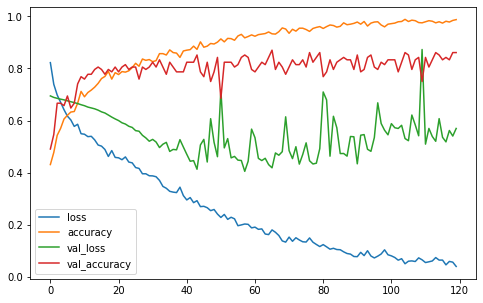

Results for fold 7
Epoch 1/120
16/16 [==============================] - 18s 321ms/step - loss: 0.8040 - accuracy: 0.5278 - val_loss: 0.6848 - val_accuracy: 0.6667
Epoch 2/120
16/16 [==============================] - 2s 118ms/step - loss: 0.7184 - accuracy: 0.5782 - val_loss: 0.6812 - val_accuracy: 0.7407
Epoch 3/120
16/16 [==============================] - 2s 118ms/step - loss: 0.7091 - accuracy: 0.5874 - val_loss: 0.6794 - val_accuracy: 0.7222
Epoch 4/120
16/16 [==============================] - 2s 120ms/step - loss: 0.6752 - accuracy: 0.6142 - val_loss: 0.6780 - val_accuracy: 0.7315
Epoch 5/120
16/16 [==============================] - 2s 119ms/step - loss: 0.6509 - accuracy: 0.6327 - val_loss: 0.6749 - val_accuracy: 0.7593
Epoch 6/120
16/16 [==============================] - 2s 118ms/step - loss: 0.6471 - accuracy: 0.6409 - val_loss: 0.6745 - val_accuracy: 0.7222
Epoch 7/120
16/16 [==============================] - 2s 119ms/step - loss: 0.5938 - accuracy: 0.7068 - val_loss: 0.6714 - 

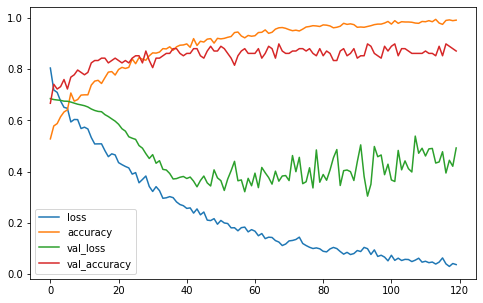

Results for fold 8
Epoch 1/120
16/16 [==============================] - 18s 318ms/step - loss: 0.8610 - accuracy: 0.4527 - val_loss: 0.6971 - val_accuracy: 0.4352
Epoch 2/120
16/16 [==============================] - 2s 121ms/step - loss: 0.7430 - accuracy: 0.5381 - val_loss: 0.6928 - val_accuracy: 0.4815
Epoch 3/120
16/16 [==============================] - 2s 119ms/step - loss: 0.7203 - accuracy: 0.5710 - val_loss: 0.6891 - val_accuracy: 0.5741
Epoch 4/120
16/16 [==============================] - 2s 119ms/step - loss: 0.6835 - accuracy: 0.5947 - val_loss: 0.6866 - val_accuracy: 0.6019
Epoch 5/120
16/16 [==============================] - 2s 120ms/step - loss: 0.6597 - accuracy: 0.6214 - val_loss: 0.6835 - val_accuracy: 0.6111
Epoch 6/120
16/16 [==============================] - 2s 118ms/step - loss: 0.6389 - accuracy: 0.6420 - val_loss: 0.6793 - val_accuracy: 0.6759
Epoch 7/120
16/16 [==============================] - 2s 117ms/step - loss: 0.6095 - accuracy: 0.6831 - val_loss: 0.6773 - 

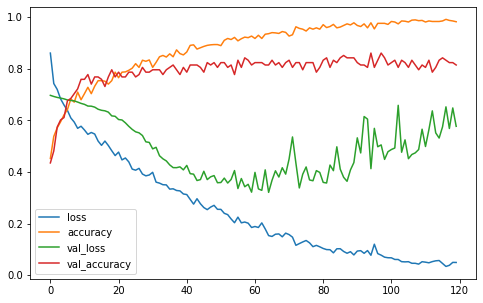

Results for fold 9
Epoch 1/120
16/16 [==============================] - 18s 318ms/step - loss: 0.8089 - accuracy: 0.4609 - val_loss: 0.6942 - val_accuracy: 0.4537
Epoch 2/120
16/16 [==============================] - 2s 118ms/step - loss: 0.7401 - accuracy: 0.5350 - val_loss: 0.6891 - val_accuracy: 0.5185
Epoch 3/120
16/16 [==============================] - 2s 117ms/step - loss: 0.6932 - accuracy: 0.5525 - val_loss: 0.6866 - val_accuracy: 0.5833
Epoch 4/120
16/16 [==============================] - 2s 118ms/step - loss: 0.6831 - accuracy: 0.5844 - val_loss: 0.6832 - val_accuracy: 0.6389
Epoch 5/120
16/16 [==============================] - 2s 116ms/step - loss: 0.6447 - accuracy: 0.6101 - val_loss: 0.6798 - val_accuracy: 0.6944
Epoch 6/120
16/16 [==============================] - 2s 120ms/step - loss: 0.6255 - accuracy: 0.6255 - val_loss: 0.6770 - val_accuracy: 0.7130
Epoch 7/120
16/16 [==============================] - 2s 116ms/step - loss: 0.6178 - accuracy: 0.6214 - val_loss: 0.6749 - 

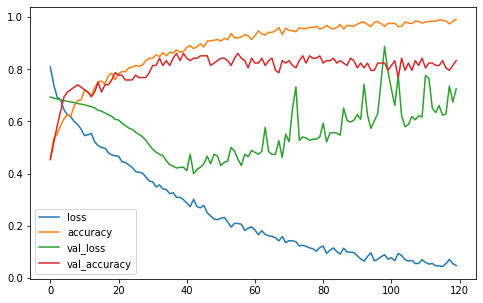

Results for fold 10
Epoch 1/120
16/16 [==============================] - 18s 318ms/step - loss: 0.7344 - accuracy: 0.5062 - val_loss: 0.6925 - val_accuracy: 0.4815
Epoch 2/120
16/16 [==============================] - 2s 119ms/step - loss: 0.6728 - accuracy: 0.5720 - val_loss: 0.6890 - val_accuracy: 0.5833
Epoch 3/120
16/16 [==============================] - 2s 117ms/step - loss: 0.6705 - accuracy: 0.5926 - val_loss: 0.6855 - val_accuracy: 0.6667
Epoch 4/120
16/16 [==============================] - 2s 118ms/step - loss: 0.6474 - accuracy: 0.6193 - val_loss: 0.6821 - val_accuracy: 0.6667
Epoch 5/120
16/16 [==============================] - 2s 118ms/step - loss: 0.6252 - accuracy: 0.6358 - val_loss: 0.6791 - val_accuracy: 0.7407
Epoch 6/120
16/16 [==============================] - 2s 119ms/step - loss: 0.6084 - accuracy: 0.6636 - val_loss: 0.6764 - val_accuracy: 0.7593
Epoch 7/120
16/16 [==============================] - 2s 118ms/step - loss: 0.6100 - accuracy: 0.6512 - val_loss: 0.6735 -

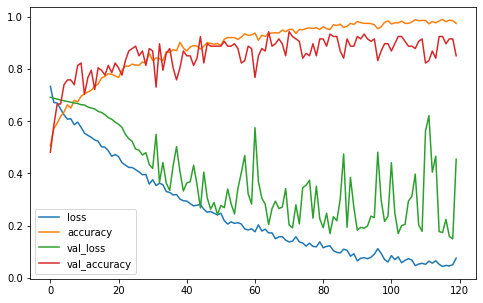

In [ ]:
val_res = {'accuracy': [], 'f1_score': [], 'confusion_matrix': []}
foldNum=0
#model = get_model()
for train_index, val_index in kfold.split(X_train, Y_train):
  foldNum = foldNum + 1
  model = get_model()
  print("Results for fold",foldNum)
  x_train, x_val = X_train[train_index], X_train[val_index]
  y_train, y_val = Y_train[train_index], Y_train[val_index]
  class_weight = call_class_weights(y_train)
  history = model.fit(x_train, y_train, epochs=epochs, class_weight=class_weight, batch_size=batch_size, verbose=1, validation_data=(x_val, y_val),shuffle=True)
  acc = model.evaluate(x_test, y_test)
  print(acc)
  val_res['accuracy'].append(acc)
  pred = model.predict(x_test)
  f1scr = f1_score(y_test.argmax(1), pred.argmax(1), average='macro')
  print(f1scr)
  pd.DataFrame(history.history).plot(figsize=(8,5))
  plt.show()
  val_res['f1_score'].append(f1scr)
  val_res['confusion_matrix'].append(confusion_matrix(y_test.argmax(1), pred.argmax(1)))
  gc.collect() # Garbage collecter
  del x_train, x_val, y_train, y_val, acc, f1scr
  gc.collect()

Accuracy  : 0.7966666698455811
F1_Score  : 0.7745966323709919


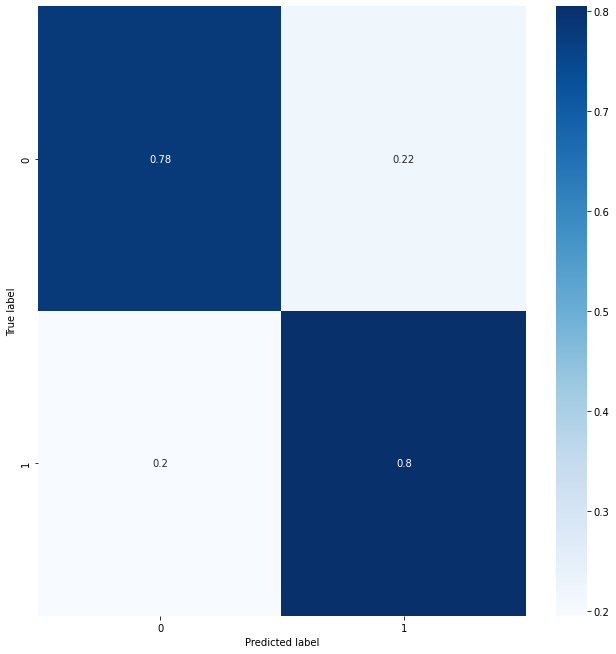

In [ ]:
#50 epochs
acrc = np.array(val_res['accuracy']).mean(axis=0)
f1scr = np.array(val_res['f1_score']).mean(axis=0)
print("Accuracy  : {}".format(acrc[1]))
print("F1_Score  : {}".format(f1scr))
cmatrix = np.array(val_res['confusion_matrix']).mean(axis=0)
c_matrix = cmatrix/np.sum(cmatrix, axis=1).reshape(2,1)
import seaborn as sns
figure = plt.figure(figsize=(9, 9))
sns.heatmap(c_matrix, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# **Arousal**

In [ ]:
#arousal
X_train, x_test, Y_train, y_test = train_test_split(data,arousal, test_size=0.1, random_state=4)
print(X_train.shape,x_test.shape,Y_train.shape,y_test.shape)

(1080, 256, 36) (120, 256, 36) (1080, 2) (120, 2)


Results for fold 1
Epoch 1/120
16/16 [==============================] - 18s 318ms/step - loss: 0.9208 - accuracy: 0.5576 - val_loss: 0.6890 - val_accuracy: 0.5370
Epoch 2/120
16/16 [==============================] - 2s 115ms/step - loss: 0.7913 - accuracy: 0.5967 - val_loss: 0.6856 - val_accuracy: 0.6204
Epoch 3/120
16/16 [==============================] - 2s 115ms/step - loss: 0.7492 - accuracy: 0.6080 - val_loss: 0.6854 - val_accuracy: 0.5556
Epoch 4/120
16/16 [==============================] - 2s 117ms/step - loss: 0.7174 - accuracy: 0.6019 - val_loss: 0.6859 - val_accuracy: 0.5741
Epoch 5/120
16/16 [==============================] - 2s 115ms/step - loss: 0.6836 - accuracy: 0.6409 - val_loss: 0.6858 - val_accuracy: 0.5926
Epoch 6/120
16/16 [==============================] - 2s 117ms/step - loss: 0.6622 - accuracy: 0.6440 - val_loss: 0.6845 - val_accuracy: 0.6019
Epoch 7/120
16/16 [==============================] - 2s 115ms/step - loss: 0.6336 - accuracy: 0.6626 - val_loss: 0.6827 - 

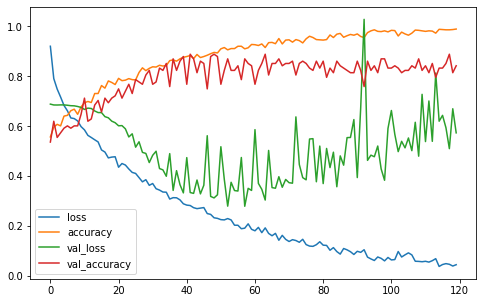

Results for fold 2
Epoch 1/120
16/16 [==============================] - 18s 318ms/step - loss: 0.8085 - accuracy: 0.5545 - val_loss: 0.6898 - val_accuracy: 0.5648
Epoch 2/120
16/16 [==============================] - 2s 118ms/step - loss: 0.7346 - accuracy: 0.5833 - val_loss: 0.6877 - val_accuracy: 0.6111
Epoch 3/120
16/16 [==============================] - 2s 117ms/step - loss: 0.7319 - accuracy: 0.5741 - val_loss: 0.6849 - val_accuracy: 0.6481
Epoch 4/120
16/16 [==============================] - 2s 115ms/step - loss: 0.6995 - accuracy: 0.5885 - val_loss: 0.6824 - val_accuracy: 0.6852
Epoch 5/120
16/16 [==============================] - 2s 116ms/step - loss: 0.6497 - accuracy: 0.6399 - val_loss: 0.6807 - val_accuracy: 0.6944
Epoch 6/120
16/16 [==============================] - 2s 119ms/step - loss: 0.6358 - accuracy: 0.6626 - val_loss: 0.6775 - val_accuracy: 0.7222
Epoch 7/120
16/16 [==============================] - 2s 114ms/step - loss: 0.6192 - accuracy: 0.6502 - val_loss: 0.6743 - 

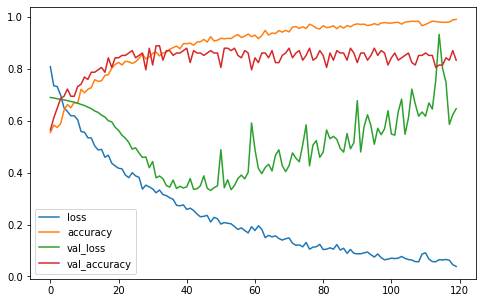

Results for fold 3
Epoch 1/120
16/16 [==============================] - 18s 312ms/step - loss: 0.7518 - accuracy: 0.5761 - val_loss: 0.6878 - val_accuracy: 0.6481
Epoch 2/120
16/16 [==============================] - 2s 117ms/step - loss: 0.6934 - accuracy: 0.5926 - val_loss: 0.6887 - val_accuracy: 0.6019
Epoch 3/120
16/16 [==============================] - 2s 112ms/step - loss: 0.6938 - accuracy: 0.6049 - val_loss: 0.6892 - val_accuracy: 0.5278
Epoch 4/120
16/16 [==============================] - 2s 117ms/step - loss: 0.6669 - accuracy: 0.6265 - val_loss: 0.6892 - val_accuracy: 0.5648
Epoch 5/120
16/16 [==============================] - 2s 116ms/step - loss: 0.6394 - accuracy: 0.6399 - val_loss: 0.6896 - val_accuracy: 0.5185
Epoch 6/120
16/16 [==============================] - 2s 118ms/step - loss: 0.6312 - accuracy: 0.6574 - val_loss: 0.6899 - val_accuracy: 0.5000
Epoch 7/120
16/16 [==============================] - 2s 115ms/step - loss: 0.6280 - accuracy: 0.6461 - val_loss: 0.6889 - 

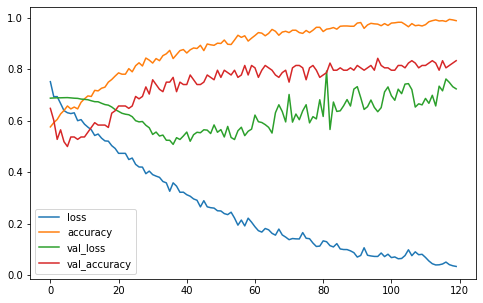

Results for fold 4
Epoch 1/120
16/16 [==============================] - 18s 317ms/step - loss: 0.9019 - accuracy: 0.4352 - val_loss: 0.6918 - val_accuracy: 0.5093
Epoch 2/120
16/16 [==============================] - 2s 118ms/step - loss: 0.8170 - accuracy: 0.4835 - val_loss: 0.6820 - val_accuracy: 0.6204
Epoch 3/120
16/16 [==============================] - 2s 118ms/step - loss: 0.7739 - accuracy: 0.5165 - val_loss: 0.6777 - val_accuracy: 0.6574
Epoch 4/120
16/16 [==============================] - 2s 118ms/step - loss: 0.7211 - accuracy: 0.5576 - val_loss: 0.6735 - val_accuracy: 0.7222
Epoch 5/120
16/16 [==============================] - 2s 114ms/step - loss: 0.7274 - accuracy: 0.5370 - val_loss: 0.6739 - val_accuracy: 0.7593
Epoch 6/120
16/16 [==============================] - 2s 117ms/step - loss: 0.6528 - accuracy: 0.5895 - val_loss: 0.6720 - val_accuracy: 0.7685
Epoch 7/120
16/16 [==============================] - 2s 113ms/step - loss: 0.6467 - accuracy: 0.6224 - val_loss: 0.6681 - 

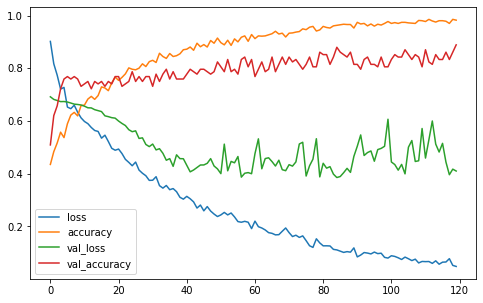

Results for fold 5
Epoch 1/120
16/16 [==============================] - 18s 315ms/step - loss: 0.7664 - accuracy: 0.5597 - val_loss: 0.6898 - val_accuracy: 0.5833
Epoch 2/120
16/16 [==============================] - 2s 118ms/step - loss: 0.7110 - accuracy: 0.5905 - val_loss: 0.6847 - val_accuracy: 0.6204
Epoch 3/120
16/16 [==============================] - 2s 118ms/step - loss: 0.6739 - accuracy: 0.6235 - val_loss: 0.6832 - val_accuracy: 0.6296
Epoch 4/120
16/16 [==============================] - 2s 115ms/step - loss: 0.6533 - accuracy: 0.6327 - val_loss: 0.6814 - val_accuracy: 0.6111
Epoch 5/120
16/16 [==============================] - 2s 116ms/step - loss: 0.6250 - accuracy: 0.6481 - val_loss: 0.6790 - val_accuracy: 0.6667
Epoch 6/120
16/16 [==============================] - 2s 119ms/step - loss: 0.6012 - accuracy: 0.6831 - val_loss: 0.6779 - val_accuracy: 0.6759
Epoch 7/120
16/16 [==============================] - 2s 120ms/step - loss: 0.5875 - accuracy: 0.6852 - val_loss: 0.6740 - 

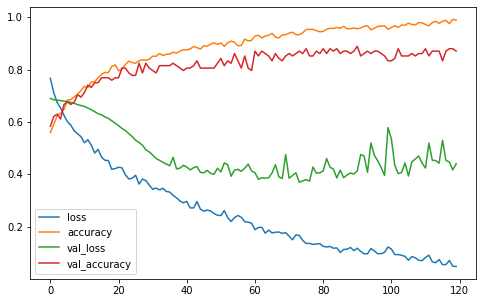

Results for fold 6
Epoch 1/120
16/16 [==============================] - 18s 322ms/step - loss: 0.7704 - accuracy: 0.5802 - val_loss: 0.6831 - val_accuracy: 0.6481
Epoch 2/120
16/16 [==============================] - 2s 119ms/step - loss: 0.7431 - accuracy: 0.5638 - val_loss: 0.6833 - val_accuracy: 0.6111
Epoch 3/120
16/16 [==============================] - 2s 118ms/step - loss: 0.6713 - accuracy: 0.6348 - val_loss: 0.6843 - val_accuracy: 0.6296
Epoch 4/120
16/16 [==============================] - 2s 119ms/step - loss: 0.6518 - accuracy: 0.6430 - val_loss: 0.6838 - val_accuracy: 0.6204
Epoch 5/120
16/16 [==============================] - 2s 120ms/step - loss: 0.6397 - accuracy: 0.6626 - val_loss: 0.6838 - val_accuracy: 0.6111
Epoch 6/120
16/16 [==============================] - 2s 119ms/step - loss: 0.6006 - accuracy: 0.6708 - val_loss: 0.6839 - val_accuracy: 0.6019
Epoch 7/120
16/16 [==============================] - 2s 120ms/step - loss: 0.6120 - accuracy: 0.6584 - val_loss: 0.6850 - 

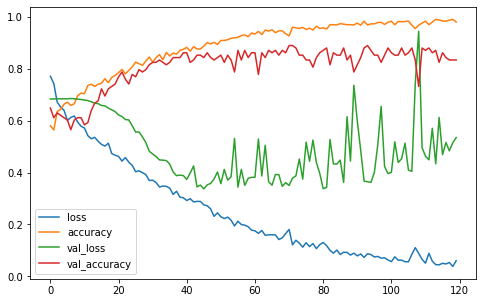

Results for fold 7
Epoch 1/120
16/16 [==============================] - 18s 318ms/step - loss: 0.9245 - accuracy: 0.5854 - val_loss: 0.6878 - val_accuracy: 0.5926
Epoch 2/120
16/16 [==============================] - 2s 120ms/step - loss: 0.8039 - accuracy: 0.6173 - val_loss: 0.6869 - val_accuracy: 0.5648
Epoch 3/120
16/16 [==============================] - 2s 118ms/step - loss: 0.7181 - accuracy: 0.6523 - val_loss: 0.6858 - val_accuracy: 0.6389
Epoch 4/120
16/16 [==============================] - 2s 118ms/step - loss: 0.6639 - accuracy: 0.6553 - val_loss: 0.6847 - val_accuracy: 0.6389
Epoch 5/120
16/16 [==============================] - 2s 119ms/step - loss: 0.6498 - accuracy: 0.6770 - val_loss: 0.6835 - val_accuracy: 0.6204
Epoch 6/120
16/16 [==============================] - 2s 117ms/step - loss: 0.6376 - accuracy: 0.6677 - val_loss: 0.6825 - val_accuracy: 0.6204
Epoch 7/120
16/16 [==============================] - 2s 118ms/step - loss: 0.5952 - accuracy: 0.7016 - val_loss: 0.6803 - 

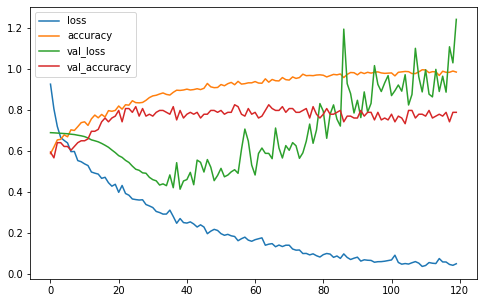

Results for fold 8
Epoch 1/120
16/16 [==============================] - 18s 317ms/step - loss: 0.8438 - accuracy: 0.5957 - val_loss: 0.6766 - val_accuracy: 0.6852
Epoch 2/120
16/16 [==============================] - 2s 118ms/step - loss: 0.7221 - accuracy: 0.6224 - val_loss: 0.6797 - val_accuracy: 0.7222
Epoch 3/120
16/16 [==============================] - 2s 116ms/step - loss: 0.7181 - accuracy: 0.6471 - val_loss: 0.6807 - val_accuracy: 0.7130
Epoch 4/120
16/16 [==============================] - 2s 119ms/step - loss: 0.6706 - accuracy: 0.6595 - val_loss: 0.6813 - val_accuracy: 0.6574
Epoch 5/120
16/16 [==============================] - 2s 117ms/step - loss: 0.6484 - accuracy: 0.6739 - val_loss: 0.6816 - val_accuracy: 0.6019
Epoch 6/120
16/16 [==============================] - 2s 115ms/step - loss: 0.6346 - accuracy: 0.6698 - val_loss: 0.6802 - val_accuracy: 0.5833
Epoch 7/120
16/16 [==============================] - 2s 116ms/step - loss: 0.6105 - accuracy: 0.6852 - val_loss: 0.6803 - 

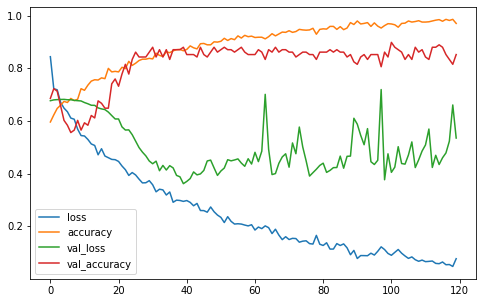

Results for fold 9
Epoch 1/120
16/16 [==============================] - 18s 320ms/step - loss: 0.8339 - accuracy: 0.4949 - val_loss: 0.6893 - val_accuracy: 0.5463
Epoch 2/120
16/16 [==============================] - 2s 114ms/step - loss: 0.7676 - accuracy: 0.5422 - val_loss: 0.6850 - val_accuracy: 0.5648
Epoch 3/120
16/16 [==============================] - 2s 119ms/step - loss: 0.7086 - accuracy: 0.5813 - val_loss: 0.6811 - val_accuracy: 0.5741
Epoch 4/120
16/16 [==============================] - 2s 114ms/step - loss: 0.6910 - accuracy: 0.6029 - val_loss: 0.6783 - val_accuracy: 0.6019
Epoch 5/120
16/16 [==============================] - 2s 114ms/step - loss: 0.6640 - accuracy: 0.6317 - val_loss: 0.6788 - val_accuracy: 0.6389
Epoch 6/120
16/16 [==============================] - 2s 114ms/step - loss: 0.6658 - accuracy: 0.6204 - val_loss: 0.6741 - val_accuracy: 0.6574
Epoch 7/120
16/16 [==============================] - 2s 116ms/step - loss: 0.6287 - accuracy: 0.6626 - val_loss: 0.6717 - 

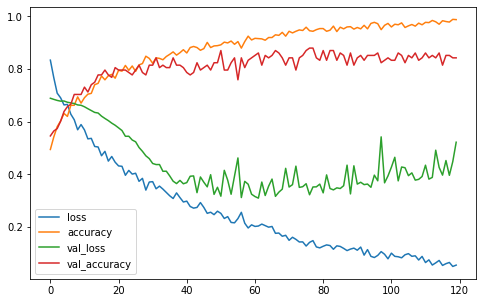

Results for fold 10
Epoch 1/120
16/16 [==============================] - 18s 320ms/step - loss: 0.7327 - accuracy: 0.5391 - val_loss: 0.6870 - val_accuracy: 0.5833
Epoch 2/120
16/16 [==============================] - 2s 116ms/step - loss: 0.7068 - accuracy: 0.5710 - val_loss: 0.6857 - val_accuracy: 0.6204
Epoch 3/120
16/16 [==============================] - 2s 114ms/step - loss: 0.7130 - accuracy: 0.5473 - val_loss: 0.6839 - val_accuracy: 0.6574
Epoch 4/120
16/16 [==============================] - 2s 120ms/step - loss: 0.6627 - accuracy: 0.6163 - val_loss: 0.6827 - val_accuracy: 0.6481
Epoch 5/120
16/16 [==============================] - 2s 116ms/step - loss: 0.6359 - accuracy: 0.6368 - val_loss: 0.6806 - val_accuracy: 0.6759
Epoch 6/120
16/16 [==============================] - 2s 120ms/step - loss: 0.6337 - accuracy: 0.6379 - val_loss: 0.6787 - val_accuracy: 0.7037
Epoch 7/120
16/16 [==============================] - 2s 117ms/step - loss: 0.6173 - accuracy: 0.6615 - val_loss: 0.6764 -

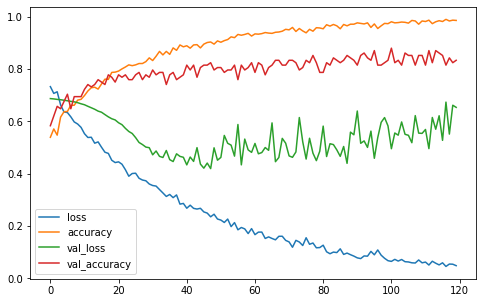

In [ ]:
val_res = {'accuracy': [], 'f1_score': [], 'confusion_matrix': []}
foldNum=0
#model = get_model()
for train_index, val_index in kfold.split(X_train, Y_train):
  foldNum = foldNum + 1
  model = get_model()
  print("Results for fold",foldNum)
  x_train, x_val = X_train[train_index], X_train[val_index]
  y_train, y_val = Y_train[train_index], Y_train[val_index]
  class_weight = call_class_weights(y_train)
  history = model.fit(x_train, y_train, epochs=epochs, class_weight=class_weight, batch_size=batch_size, verbose=1, validation_data=(x_val, y_val),shuffle=True)
  acc = model.evaluate(x_test, y_test)
  print(acc)
  val_res['accuracy'].append(acc)
  pred = model.predict(x_test)
  f1scr = f1_score(y_test.argmax(1), pred.argmax(1), average='macro')
  print(f1scr)
  pd.DataFrame(history.history).plot(figsize=(8,5))
  plt.show()
  val_res['f1_score'].append(f1scr)
  val_res['confusion_matrix'].append(confusion_matrix(y_test.argmax(1), pred.argmax(1)))
  gc.collect() # Garbage collecter
  del x_train, x_val, y_train, y_val, acc, f1scr
  gc.collect()

Accuracy  : 0.825
F1_Score  : 0.8152500412654875


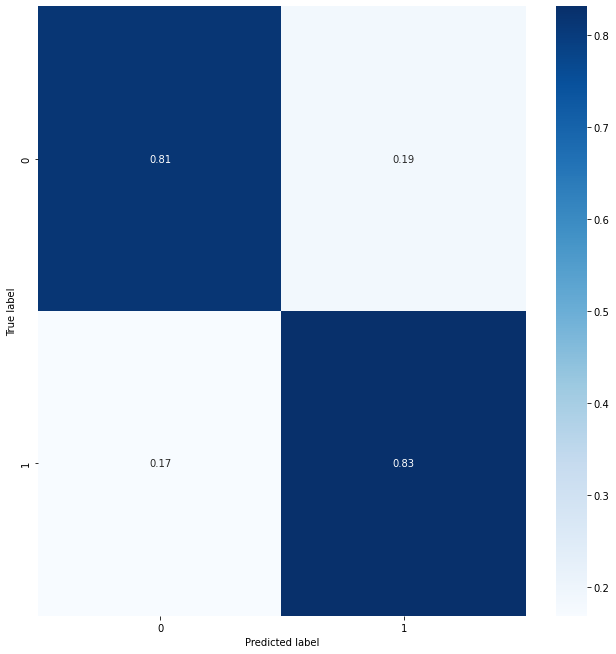

In [ ]:
acrc = np.array(val_res['accuracy']).mean(axis=0)
f1scr = np.array(val_res['f1_score']).mean(axis=0)
print("Accuracy  : {}".format(acrc[1]))
print("F1_Score  : {}".format(f1scr))
cmatrix = np.array(val_res['confusion_matrix']).mean(axis=0)
c_matrix = cmatrix/np.sum(cmatrix, axis=1).reshape(2,1)
import seaborn as sns
figure = plt.figure(figsize=(9, 9))
sns.heatmap(c_matrix, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()